# Package rationale

Package consists of: 
* Header 24 bytes: MXTP** (little endian, char) + metadata (depends, see *parse_header*)
* List of Items:
    * Item (segment or sensor): Item_index (int32, big endian) + List of features
        * Feature (float32, big endian)


In [24]:
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dt
import socket
import time
import os
import pandas as pd


%matplotlib widget

PORT = 9763 # port to read from
HOST = '0.0.0.0' # 0.0.0.0 - means to read all incoming connections

df_segments = pd.DataFrame("""Pelvis
L5
L3
T12
T8
Neck
Head
Right Shoulder
Right Upper Arm
Right Forearm
Right Hand
Left Shoulder
Left Upper Arm
Left Forearm
Left Hand
Right Upper Leg
Right Lower Leg 
Right Foot
Right Toe
Left Upper Leg
Left Lower Leg
Left Foot
Left Toe
Prop1
Prop2
Prop3
Prop4""".split('\n'), columns=['Name'])

MXTP_HEADER_LEN = 24
FEATURE_BYTES = 4

def parse_header(pack):
    if (pack[:4].decode() == 'MXTP'):
        header = {};
        header['type'] = int(data[4:6].decode('UTF-8')) # type of package
        header['sample_counter'] = int.from_bytes(data[6:10], 'big', signed=True); # sample number since streaming launch
        header['datagram_counter'] = data[10]; # ???
        header['n_items'] = data[11]; # number of items in package
        header['timestamp'] = int.from_bytes(data[12:16], 'big', signed=True); # !!! not tested, could be simply a timestamp in ms
        header['avatar_id'] = data[16]; # ????
        header['n_body_seg'] = data[17]; # ????
        header['n_props'] = data[18]; # ????
        header['n_finger'] = data[19]; # ????
        header['n_payload_bytes'] = int.from_bytes(data[20:24], 'big', signed=True); # seems like the number of payload bytes
    
        return header
    
    else:
        return None

In [4]:
max_frames = 200;
n_frames = 0;

frames = [] # for online processing only
headers = [] # for online processing only

exp_name = dt.now().strftime('%Y-%m-%d_%H-%M-%S')
log_path = os.path.join('Data', exp_name + '.xsens')

with socket.socket(socket.AF_INET, socket.SOCK_DGRAM) as s:
    
    s.bind((HOST, PORT))
    print('Socket', s)
    
    with open(log_path, 'wb') as log_file:
        
        while (n_frames<max_frames):
            
            data, addr = s.recvfrom(4096)
            header = parse_header(data);
            
            # check header
            if (header is None):
                continue
                
            log_file.write(data) # logging all incoming connection

            item_bytes = header['n_payload_bytes']//header['n_items'] # bytes reserved for each item
            n_features = item_bytes // FEATURE_BYTES # number of features in item

            frame = np.zeros((header['n_items'], n_features), dtype='float32')

            print(header, end='\r')

            for item_idx in range(header['n_items']):
                frame[item_idx, 0]  = int.from_bytes(data[MXTP_HEADER_LEN + item_idx * item_bytes: 
                                                          MXTP_HEADER_LEN + item_idx * item_bytes + FEATURE_BYTES], 'big')

                frame[item_idx, 1:] = np.frombuffer(data[MXTP_HEADER_LEN + item_idx * item_bytes + FEATURE_BYTES: 
                                                         MXTP_HEADER_LEN + (item_idx+1) * item_bytes], 'float32').byteswap()

            frames.append(frame)
            headers.append(header)
    #         print(frame[15,:4], end='                      \r')
    #         n_frames+=1;


Socket <socket.socket fd=79, family=AddressFamily.AF_INET, type=SocketKind.SOCK_DGRAM, proto=0, laddr=('0.0.0.0', 9763)>


KeyboardInterrupt: 

In [11]:
frames = np.stack(frames)
df_headers = pd.DataFrame(headers)
df_headers.index.name = 'Frame'
print(frames.shape)
df_headers

(317, 7, 17)


,type,sample_counter,datagram_counter,n_items,timestamp,avatar_id,n_body_seg,n_props,n_finger,n_payload_bytes
Frame,,,,,,,,,,
0,23,6119,128,7,51451758,0,23,0,0,476
1,23,6122,128,7,51451788,0,23,0,0,476
2,23,6125,128,7,51451817,0,23,0,0,476
3,23,6127,128,7,51451838,0,23,0,0,476
4,23,6130,128,7,51451867,0,23,0,0,476
...,...,...,...,...,...,...,...,...,...,...
312,23,6980,128,7,51460367,0,23,0,0,476
313,23,6982,128,7,51460387,0,23,0,0,476
314,23,6986,128,7,51460427,0,23,0,0,476


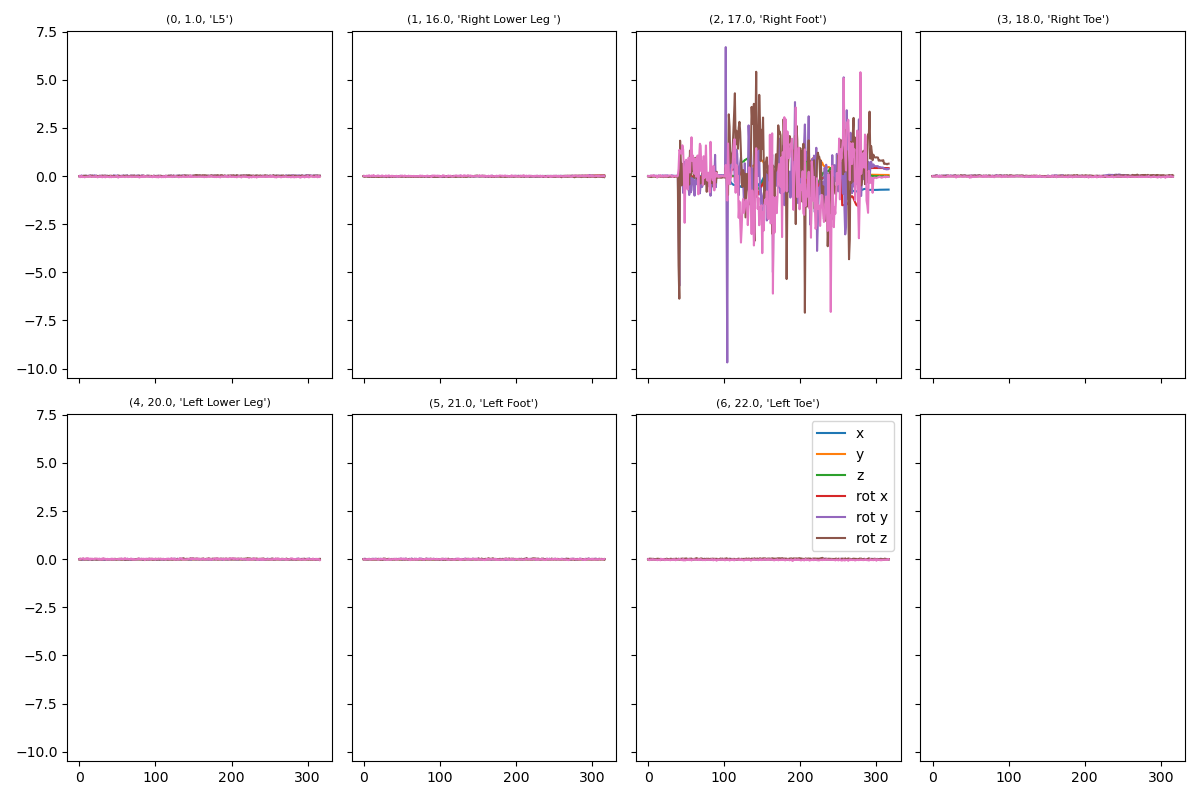

In [31]:
fig, axx = plt.subplots(int(np.ceil(header['n_items']/4)), 4, sharex=True, sharey=True, figsize=(12,8))

for i in range(header['n_items']):

    plt.sca(axx.reshape(-1)[i])

    target = frames[:, i, 1:8].copy()

    plt.plot(target - target[[0], :])

    plt.title((i, frames[0][i][0], df_segments.iloc[int(frames[0][i][0])].Name), fontsize=8)

plt.legend(['x', 'y', 'z', 'rot x', 'rot y', 'rot z'])
plt.tight_layout()